# Section 3: Unsupervised learning – Clustering
In this unsupervised learning task, the objective is to cluster Reddit comments based on the words used
within them. The aim is to identify patterns and group comments with similar words together. 
Note: Use only the column body (i.e. the textual data) to extract the features used in this section, do not
feed “author”, “subreddit” and “created_utc” to the model.


In [1]:
# all required imports
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
%pip install wordcloud
from wordcloud import WordCloud

Note: you may need to restart the kernel to use updated packages.


In [7]:
# load clean unsupervised dataset
df_unsup = pd.read_csv("../data/clean_unsupervised.csv")

# look number of comments
print(f"Number of comments: {len(df_unsup)}")
print(f"{df_unsup.head(10)}")
print(f"Unsupervised dimension: {df_unsup.shape}")


Number of comments: 1107946
               author        subreddit   created_utc  \
0       ejchristian86  TwoXChromosomes  1.388534e+09   
1           ZenDragon           gaming  1.388534e+09   
2        savoytruffle        AskReddit  1.388534e+09   
3        hentercenter     stlouisblues  1.388534e+09   
4        rick-o-suave             army  1.388534e+09   
5        olivermihoff    AdviceAnimals  1.388534e+09   
6           Cleriesse        AskReddit  1.388534e+09   
7   murderer_of_death    MorbidReality  1.388534e+09   
8          SpiralSoul   Pathfinder_RPG  1.388534e+09   
9  IRideVelociraptors       FreeEBOOKS  1.388534e+09   

                                                body  \
0  I hadn't ever heard of them before joining thi...   
1                At 7680 by 4320 with 64x AA, right?   
2                                            bite me   
3                    Damn that was a good penalty :(   
4  I swore into DEP on 6-OCT and I left 5-NOV und...   
5  Not that it's ev

In [ ]:
# Informations about the cleaned comments
df_unsup['body_clean'].str.len().describe()
df_unsup.shape


(1107946, 6)

In [8]:
# to avoid dominance of highly active subreddits, we sample at most N comments per subreddit
def balanced_sampling(dataframe, group_column="subreddit", max_comments = 500, random_state=42):
      return (
        dataframe.groupby(group_column, group_keys=False)
          .apply(lambda x: x.sample(
              n=min(len(x), max_comments),
              random_state=random_state
          ))
    )

df_sample = balanced_sampling(df_unsup, group_column="subreddit", max_comments=500)

print(f"Sampled comments: {len(df_sample)}")
df_sample["subreddit"].value_counts().head()

Sampled comments: 343114


C:\Users\bonio\AppData\Local\Temp\ipykernel_5284\1345207543.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


subreddit
wow          500
sex          500
self         500
seduction    500
DotA2        500
Name: count, dtype: int64

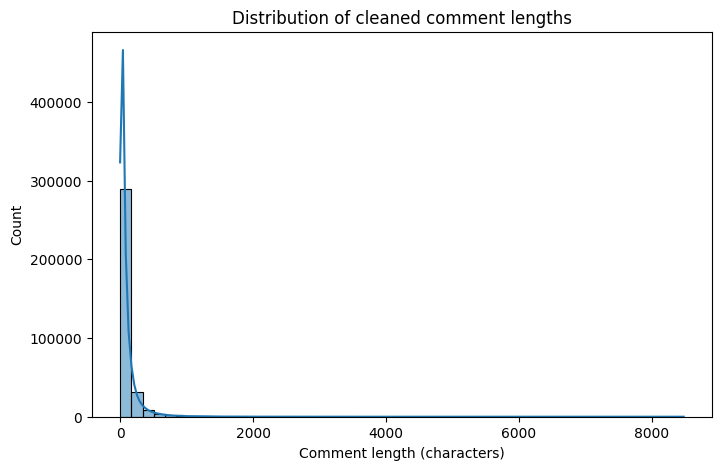

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df_sample['body_clean'].str.len(), bins=50, kde=True)
plt.title("Distribution of cleaned comment lengths")
plt.xlabel("Comment length (characters)")
plt.ylabel("Count")
plt.show()

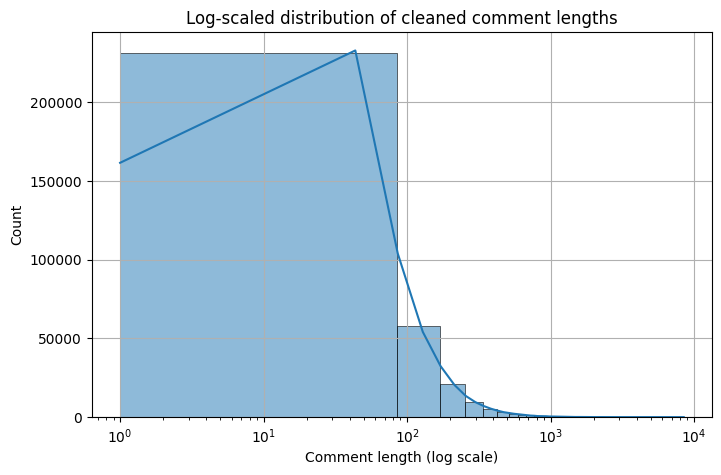

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df_sample['body_clean'].str.len(), bins=100, kde=True)
plt.xscale('log')
plt.title("Log-scaled distribution of cleaned comment lengths")
plt.xlabel("Comment length (log scale)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

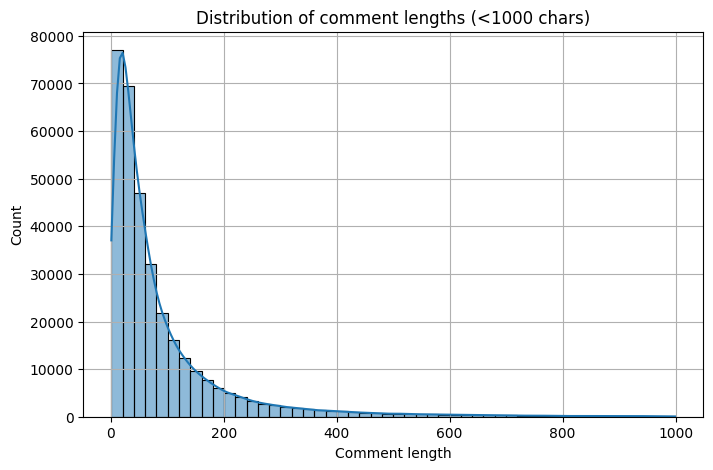

In [16]:
filtered_lengths = df_sample['body_clean'].str.len()
filtered_lengths = filtered_lengths[filtered_lengths < 1000]

plt.figure(figsize=(8,5))
sns.histplot(filtered_lengths, bins=50, kde=True)
plt.title("Distribution of comment lengths (<1000 chars)")
plt.xlabel("Comment length")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [9]:
# Remove empty documents / with missing data 
df_sample = df_sample.dropna(subset=['body_clean'])
df_sample = df_sample[df_sample['body_clean'].str.strip() != ""]
df_sample['body_clean'] = df_sample['body_clean'].astype(str)

print(f"Dimension after cut empty stuff: {len(df_sample)}")


Dimension after cut empty stuff: 337708


### Dimensionality reduction
In this section, we apply unsupervised learning to explore patterns in Reddit comments.
Text data is transformed using TF-IDF, reduced with TruncatedSVD, and clustered using KMeans.  
We removed the custom `token_pattern` to align the TF-IDF configuration
with Section 1, relying on the default scikit-learn tokenization.
This also avoids unintentionally filtering out tokens such as emojis.

In [10]:
#  TF-IDF Vectorizer using only the cleaned text (it is in body_clean)
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=10,                  
    max_df=0.4,                
    stop_words='english', 
    ngram_range=(1, 2)          # uni-gram و bi-gram
)

X = tfidf.fit_transform(df_sample['body_clean'])
print(f"TF-IDF dimensions: {X.shape}")



TF-IDF dimensions: (337708, 10000)


In [17]:

# Dimensionality reduction with Truncated SVD

n_components = 150

svd = TruncatedSVD(n_components=n_components, random_state=42)

X_reduced = svd.fit_transform(X)

print(f"Reduced feature shape: {X_reduced.shape}")


Reduced feature shape: (337708, 150)


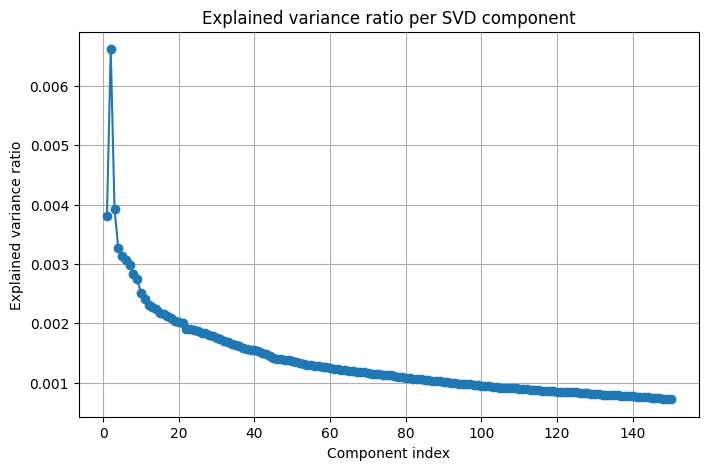

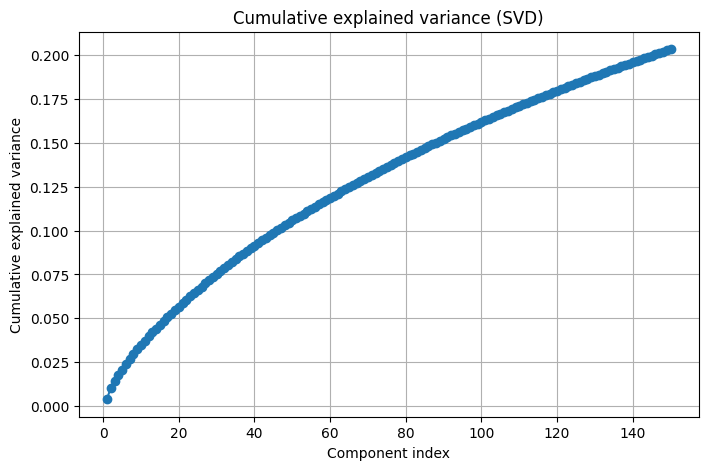

In [18]:
# describe how much variance with the first 50 features
explained = svd.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Explained variance ratio per SVD component")
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), np.cumsum(explained), marker='o')
plt.title("Cumulative explained variance (SVD)")
plt.xlabel("Component index")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()

C:\Users\bonio\AppData\Local\Temp\ipykernel_23944\1580525323.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x="mean_tfidf", y="term", palette="viridis")


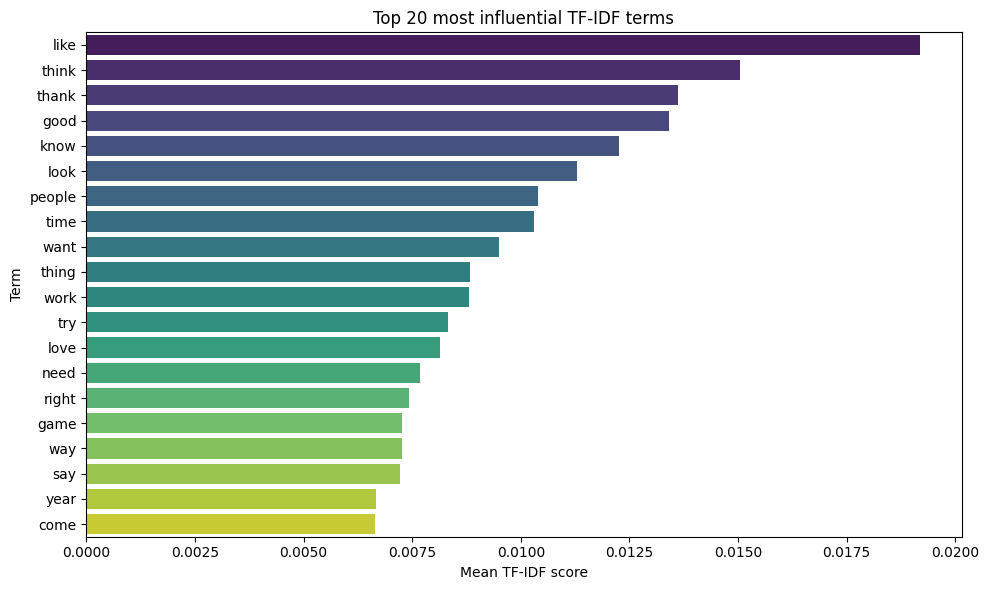

In [19]:
# Get feature names and compute mean TF-IDF score per term
feature_names = tfidf.get_feature_names_out()
tfidf_means = np.asarray(X.mean(axis=0)).ravel()

# Create dataframe
tfidf_df = pd.DataFrame({
    "term": feature_names,
    "mean_tfidf": tfidf_means
})

# Sort and take top 20
top20 = tfidf_df.sort_values(by="mean_tfidf", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top20, x="mean_tfidf", y="term", palette="viridis")
plt.title("Top 20 most influential TF-IDF terms")
plt.xlabel("Mean TF-IDF score")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

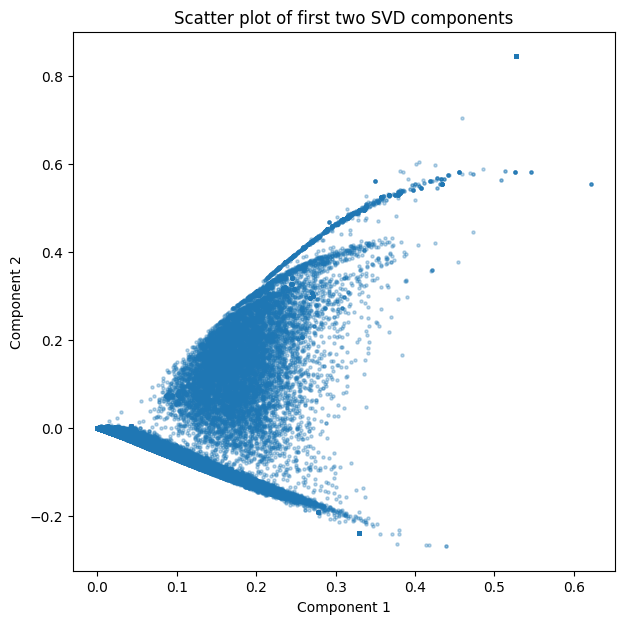

In [20]:
# first structure of data before clustering and observe if there are outliers
plt.figure(figsize=(7,7))
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=5, alpha=0.3)
plt.title("Scatter plot of first two SVD components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Clustering with K-Means  
Silhouette is the method used to measure how much a point is near and far by its cluseter. if the values are like 1 -> cluster ben distinguished, if values tend to -> 0 the clusters are overlapped.  
The number of clusters was selected using silhouette analysis, as it provides a quantitative measure of cluster separation. The silhouette score was maximized at k = X, which was therefore selected.


In [21]:
# use of AI to avoid long computation

sil_scores = []

for k in range(2, 15):
    # aggiunto da adri, problemi
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
    labels_tmp = km.fit_predict(X_reduced)

    score = silhouette_score(
        X_reduced,
        labels_tmp,
        sample_size=10000,
        random_state=42
    )

    sil_scores.append(score)
    print(f"k={k}, silhouette={score:.3f}")


k=2, silhouette=0.114
k=3, silhouette=0.051
k=4, silhouette=0.059
k=5, silhouette=0.054
k=6, silhouette=0.061
k=7, silhouette=0.037
k=8, silhouette=0.120
k=9, silhouette=0.059
k=10, silhouette=0.054
k=11, silhouette=0.025
k=12, silhouette=0.047
k=13, silhouette=-0.002
k=14, silhouette=0.026


Now we fit KMeans with te selected K

In [22]:

k = 8

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_reduced)

# attach cluster labels to the dataframe to better visualize it
df_sample = df_sample.reset_index(drop=True)
df_sample["cluster_kmeans"] = labels_km

df_sample.head(10)

,author,subreddit,created_utc,body,body_normalized,body_clean,cluster_kmeans
0,DCDVath,1022,1.390343e+09,I just picked one up myself at the gun show 2 ...,i just picked one up myself at the gun show 2 ...,pick gun 2 weekend find 22lr ammo,4
1,razor_edge,1022,1.390578e+09,No problems at all.,no problems at all.,problem,4
2,razor_edge,1022,1.389429e+09,The receiver is the only component classified ...,the receiver is the only component classified ...,receiver component classify gun buy ffl privat...,4
3,razor_edge,1022,1.390617e+09,Eley Tenex and RWS R-50 were the best of the t...,eley tenex and rws r-50 were the best of the t...,eley tenex rws r-50 good target ammo test aver...,4
4,razor_edge,1022,1.390536e+09,A conclusive deduction in an opinion? Wtf are ...,a conclusive deduction in an opinion? wtf are ...,conclusive deduction opinion wtf talk own clea...,4
5,DCDVath,1022,1.390343e+09,It will come back around one of these days. Ev...,it will come back around one of these days. ev...,come day come stock matter time yeah ya pay $ ...,4
6,razor_edge,1022,1.390538e+09,[Here is my Ultra Light 10/22 build](http://im...,[here is my ultra light 10/22 build]( . 4.4 lb...,ultra light 10/22 build 4.4 lbs/2 kg unloaded ...,4
7,DCDVath,1022,1.389629e+09,I would gladly pay a nickel a round. Just boug...,i would gladly pay a nickel a round. just boug...,gladly pay nickel round buy 10/22 weekend chea...,4
8,TrapperJon,1022,1.390964e+09,We are now due to the stupid SAFE Act... no se...,we are now due to the stupid safe act... no se...,stupid safe act semi auto detachable magazine ...,4
9,Betrivent,1022,1.389831e+09,Tap it out with a punch. From the orientation...,tap it out with a punch. from the orientation ...,tap punch orientation picture left right insta...,4


In [23]:
print(labels_km)

[4 4 4 ... 4 4 4]


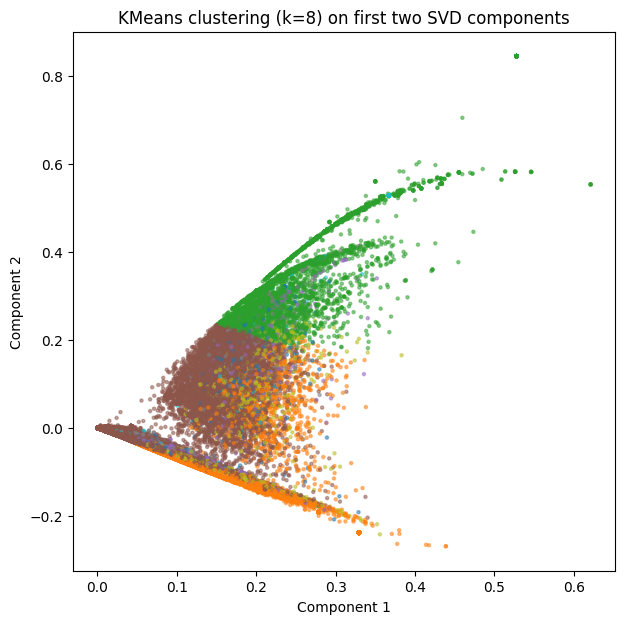

In [24]:
# plot of the two components
plt.figure(figsize=(7,7))
plt.scatter(
    X_reduced[:,0], X_reduced[:,1],
    c=labels_km, cmap="tab10", s=5, alpha=0.5
)
plt.title("KMeans clustering (k=8) on first two SVD components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

k=3, inertia=65446.81
k=4, inertia=64990.48
k=5, inertia=64169.04
k=6, inertia=62784.71
k=7, inertia=63197.16
k=8, inertia=61966.61
k=9, inertia=61250.98
k=10, inertia=60639.47
k=11, inertia=60492.96
k=12, inertia=60109.52
k=13, inertia=59753.99
k=14, inertia=59415.27
k=15, inertia=58639.02


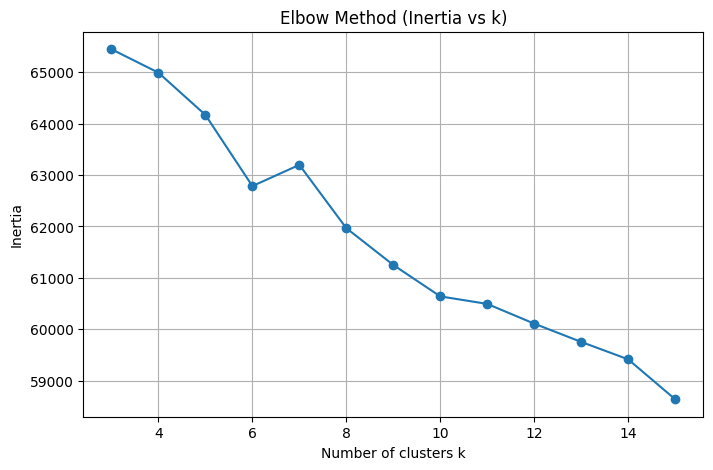

(range(3, 16),
 [65446.81338561155,
  64990.480793405004,
  64169.04339541764,
  62784.714392986025,
  63197.15945188397,
  61966.61082648625,
  61250.97832523452,
  60639.46898706266,
  60492.95813862394,
  60109.523471982786,
  59753.98836393851,
  59415.274890866036,
  58639.02025982055])

In [25]:
# find the number of cluster using eblow method
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import numpy as np

def elbow_method(X, k_min=2, k_max=15, batch_size=2048, random_state=42):
    inertias = []
    ks = range(k_min, k_max + 1)

    for k in ks:
        km = MiniBatchKMeans(
            n_clusters=k,
            batch_size=batch_size,
            random_state=random_state,
            init="k-means++",
            n_init="auto"
        )
        km.fit(X)
        inertias.append(km.inertia_)
        print(f"k={k}, inertia={km.inertia_:.2f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.title("Elbow Method (Inertia vs k)")
    plt.xlabel("Number of clusters k")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    return ks, inertias

# Esempio d’uso:
elbow_method(X_reduced, k_min=3, k_max=15)


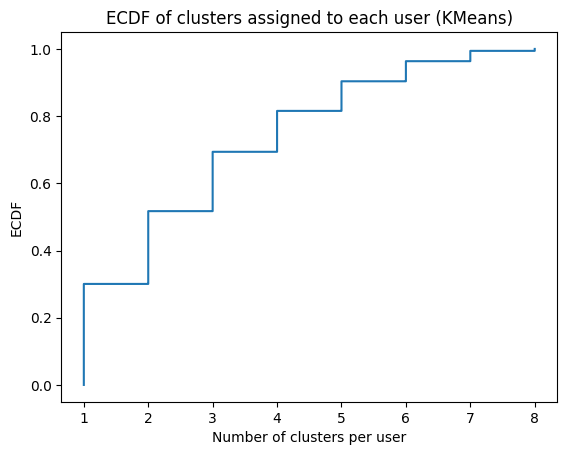

In [26]:
# User distribution analysis - ECDF
# each user can be assigned to multiple cluster because we cluster comments
# Number of distinct clusters per user
user_cluster_count = (
    df_sample.groupby("author")["cluster_kmeans"]
    .nunique()
)

# ECDF
x = np.sort(user_cluster_count.values)
y = np.arange(1, len(x) + 1) / len(x)

plt.step(x, y)
plt.xlabel("Number of clusters per user")
plt.ylabel("ECDF")
plt.title("ECDF of clusters assigned to each user (KMeans)")
plt.show()


In [27]:
print(f"Media cluster per utente: {user_cluster_count.mean():.2f}")
print(f"Deviazione standard: {user_cluster_count.std():.2f}")

Media cluster per utente: 2.81
Deviazione standard: 1.74


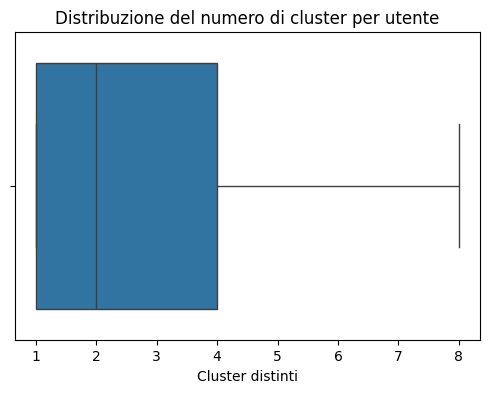

In [28]:
plt.figure(figsize=(6,4))
sns.boxplot(x=user_cluster_count)
plt.title("Distribuzione del numero di cluster per utente")
plt.xlabel("Cluster distinti")
plt.show()

In [29]:
# Cluster interpretation – Top terms
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

Cluster 0: 10 doge, 10 second, 00, 10, 10 10, 10 minute, 10 12, 100 year, 05, 07
Cluster 1: 00, 000 000, 12 hour, 1080p, 10 20, 11, 125, 10 hour, 06, 01
Cluster 2: 000, 00, 000 000, 10 year, 01, 10 000, 10 11, 08, 13 year, 11
Cluster 3: 02, 00, 04, 000 year, 10 time, 10 000, 10 12, 10 11, 100 time, 06
Cluster 4: 00, 05, 10 hour, 110, 10 year, 03, 10k, 12, 130, 16 year
Cluster 5: 10 10, 09, 07, 00, 10 15, 10 hour, 10 time, 10 day, 10, 05
Cluster 6: 000 year, 00, 01, 04, 07, 06, 11, 10 000, 10 12, 10 time
Cluster 7: 06, 07, 05, 00, 10, 03, 10 000, 10 11, 10 doge, 1080p


In [30]:
# cluster vs subreddit analysis
cluster_subreddit_dist = (
    pd.crosstab(
        df_sample["cluster_kmeans"],
        df_sample["subreddit"],
        normalize="index"
    )
)

cluster_subreddit_dist.head()


subreddit,1022,1200isplenty,1911,195,2007scape,2014goals,240sx,24hoursupport,2X_INTJ,30ROCK,...,yorku,youdontsurf,youngjustice,youtube,youtubehaiku,yugioh,zelda,zen,zombies,zyzz
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.000168,...,0.000000,0.000168,0.000000,0.000000,0.000841,0.000000,0.001346,0.000000,0.000000,0.000000
1,0.000034,0.000103,0.000034,0.000069,0.000137,0.000069,0.000034,0.000034,0.000034,0.000069,...,0.000000,0.000000,0.000034,0.000103,0.000411,0.000411,0.000480,0.000103,0.000069,0.000034
2,0.000000,0.000000,0.000000,0.000000,0.000354,0.000000,0.000000,0.000177,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000177,0.000885,0.000708,0.000708,0.000000,0.000000,0.000000
3,0.000163,0.000325,0.000163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000163,0.000000,0.000163,0.000813,0.000651,0.000651,0.000000,0.000163,0.000000
4,0.000082,0.000067,0.000056,0.000067,0.000321,0.000075,0.000078,0.000052,0.000007,0.000071,...,0.000019,0.000071,0.000011,0.000206,0.000419,0.000374,0.000572,0.000078,0.000082,0.000060


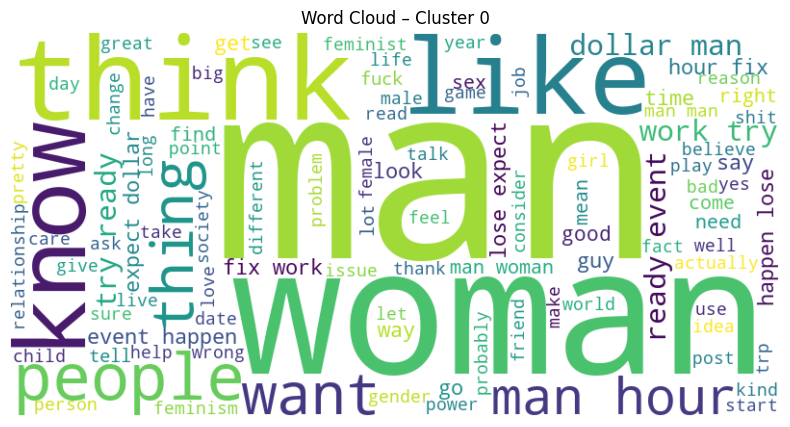

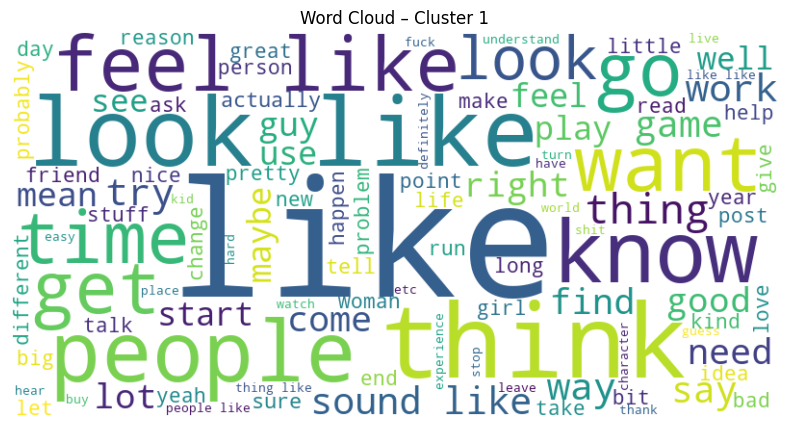

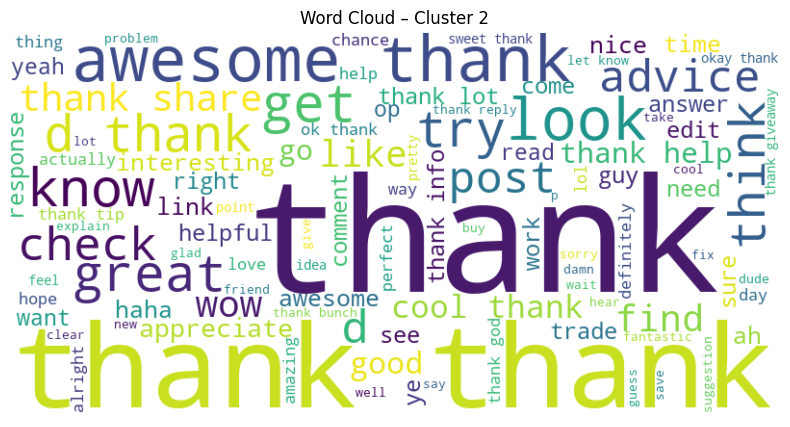

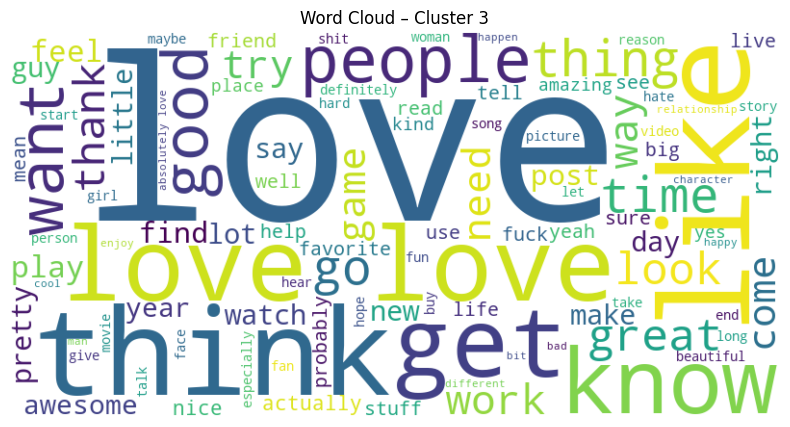

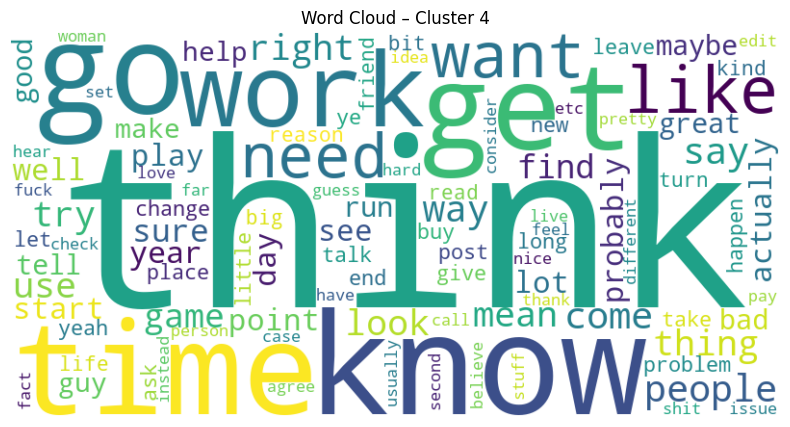

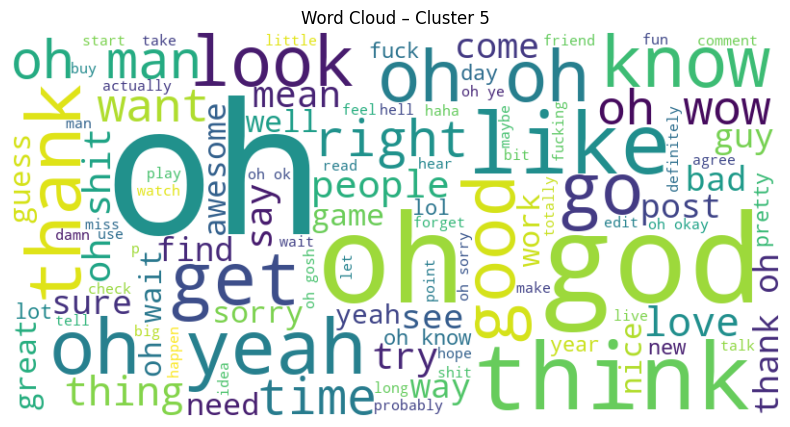

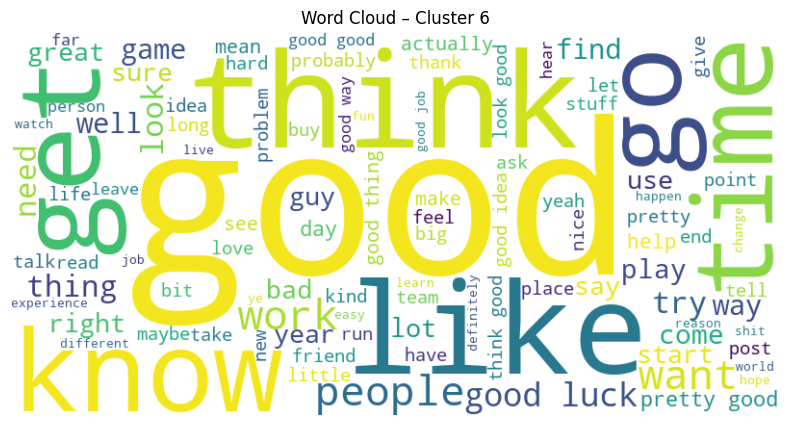

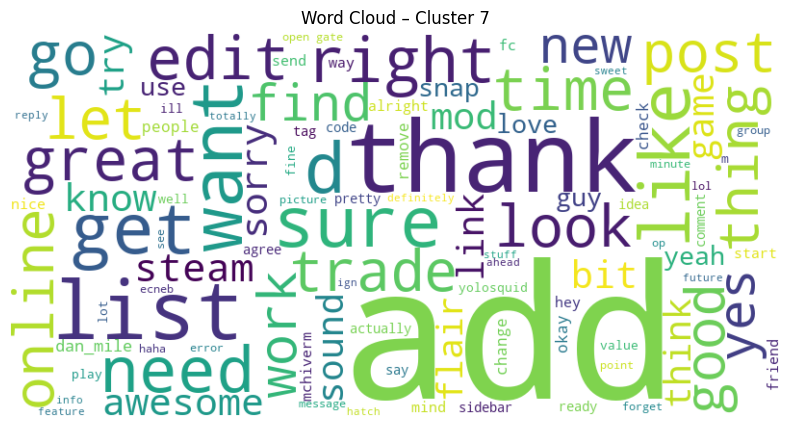

In [ ]:


for i in range(k):
    cluster_comments = df_sample[df_sample["cluster_kmeans"] == i]["body_clean"]
    text = " ".join(cluster_comments)
    wc = WordCloud(width=800, height=400, max_words=100, background_color="white", stopwords="english").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – Cluster {i}")
    plt.show()

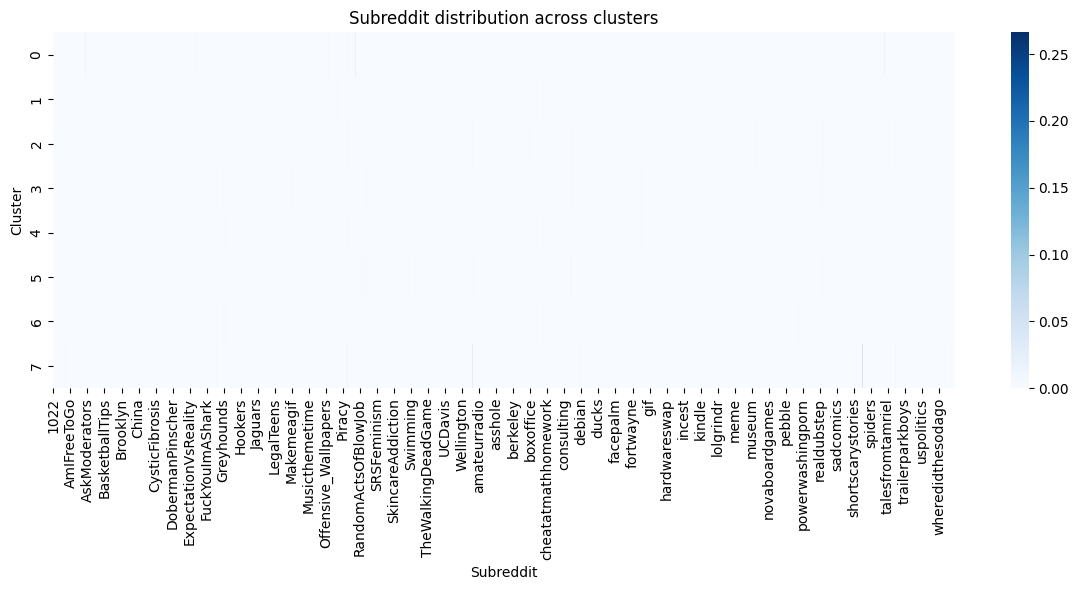

In [37]:
# Distribuzione dei subreddit per cluster


subreddit_dist = (
    df_sample.groupby("cluster_kmeans")["subreddit"]
             .value_counts(normalize=True)
             .unstack(fill_value=0)
)

plt.figure(figsize=(12,6))
sns.heatmap(subreddit_dist, cmap="Blues", annot=False)
plt.title("Subreddit distribution across clusters")
plt.xlabel("Subreddit")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

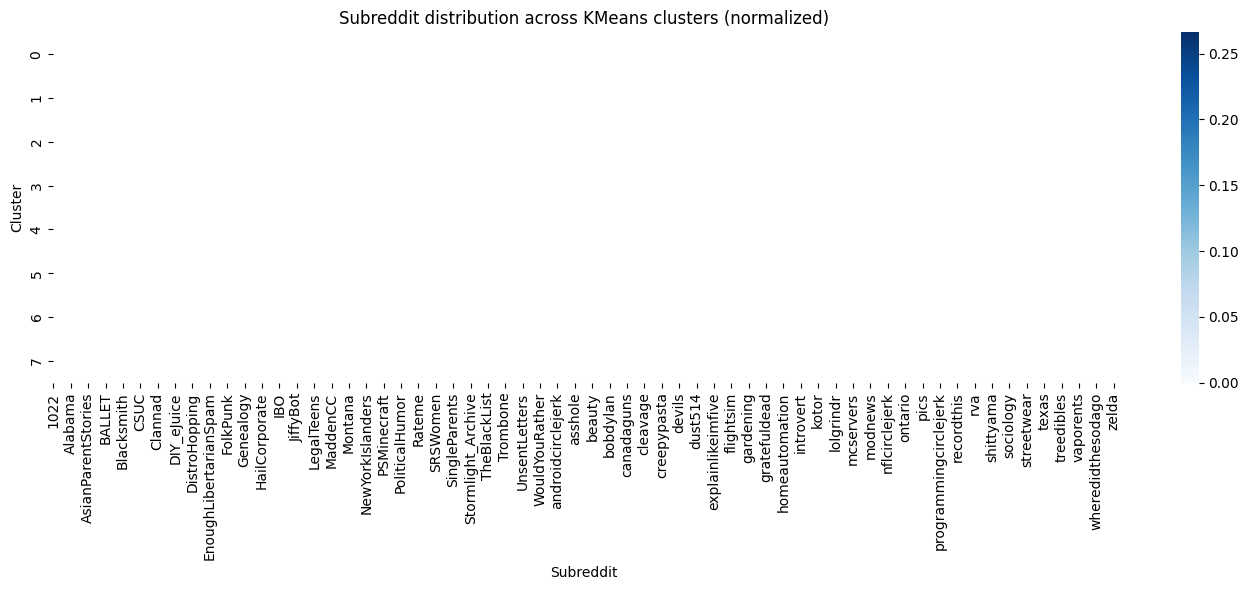

In [32]:
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_subreddit_dist, cmap="Blues", linewidths=0.3)
plt.title("Subreddit distribution across KMeans clusters (normalized)")
plt.xlabel("Subreddit")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

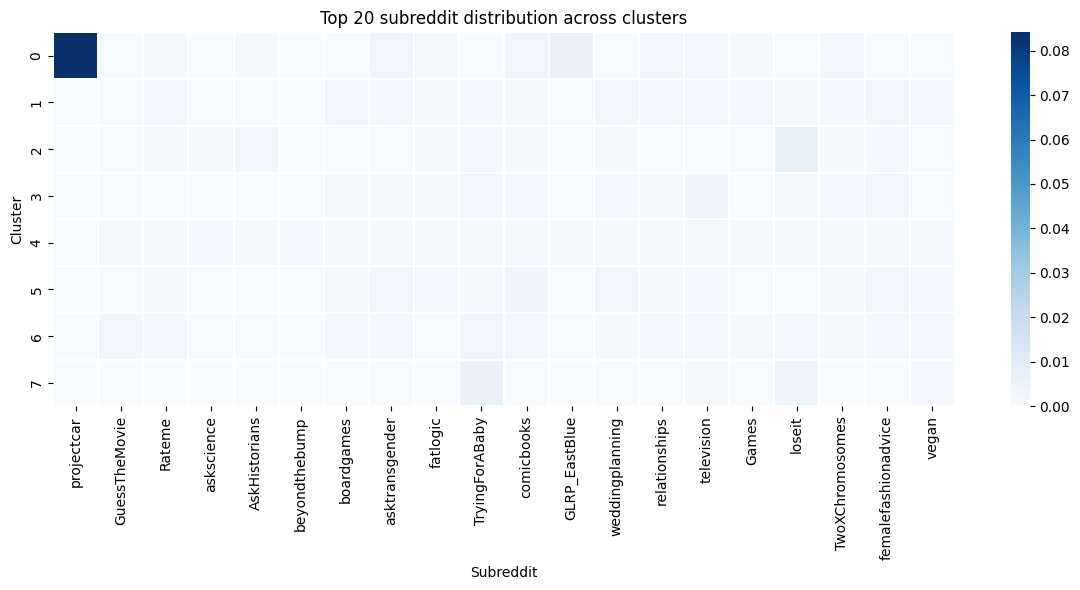

In [34]:
top_subreddits = df_sample["subreddit"].value_counts().head(20).index
filtered_dist = cluster_subreddit_dist[top_subreddits]

plt.figure(figsize=(12,6))
sns.heatmap(filtered_dist, cmap="Blues", linewidths=0.3)
plt.title("Top 20 subreddit distribution across clusters")
plt.xlabel("Subreddit")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

Per valutare la coerenza tematica dei cluster, abbiamo analizzato la distribuzione dei subreddit all’interno di ciascun gruppo. La matrice normalizzata cluster × subreddit mostra che alcuni cluster presentano una forte concentrazione su pochi subreddit, indicando una buona purezza tematica. Altri cluster risultano invece più eterogenei, suggerendo che raggruppano commenti con temi trasversali a più comunità. Questa analisi conferma che il clustering cattura parzialmente la struttura dei subreddit, pur evidenziando sovrapposizioni semantiche tra alcune comunità.

### Note on anomalous clusters

When inspecting the cluster sizes, we observe that one or two clusters are significantly larger than the others.
By manually checking their content, we found that these clusters are dominated by repeated or near-duplicate comments,
often posted many times by the same user.

These clusters therefore represent anomalous behaviour rather than meaningful semantic topics.
We keep them in the analysis for completeness, but we do not interpret them as genuine discussion themes.


In [38]:
df_sample["cluster_kmeans"].value_counts().sort_index()


cluster_kmeans
0      5945
1     29165
2      5652
3      6149
4    267572
5      4099
6     17800
7      1326
Name: count, dtype: int64

In [53]:
df_sample[df_sample["cluster"] == 1]["body"].head(15)


36     If the texture bothers you you're probably coo...
105    Is flax the best way to make money from NMZ no...
115    good idea :) do you know which items i would n...
136    At uni i would play rs and roll a j on my keyb...
137                                     The best way ^.^
169    Wow very good job! the black dragons are level...
210    I stopped biting my nails a few years ago and ...
214    The sad truth is that most are beaten up or ov...
223    Looking good. Can't wait to see the finished p...
225    Just trust me when I say its worth waiting and...
226    or Volk TE37's, I think those look the best an...
253    Are both the MB power connectors in place? Try...
270    I think 30 Rock has the best one-liners as wel...
287    looking good.  you just gonna tease or we get ...
310    Urgh!!! I'm stuck at school all day. Can't wai...
Name: body, dtype: object

In [41]:
df_sample[df_sample["cluster_kmeans"] == 4]["body"].head(20)


0     I just picked one up myself at the gun show 2 ...
1                                  No problems at all. 
2     The receiver is the only component classified ...
3     Eley Tenex and RWS R-50 were the best of the t...
4     A conclusive deduction in an opinion? Wtf are ...
5     It will come back around one of these days. Ev...
6     [Here is my Ultra Light 10/22 build](http://im...
7     I would gladly pay a nickel a round. Just boug...
8     We are now due to the stupid SAFE Act... no se...
9     Tap it out with a punch.  From the orientation...
10    &gt; How about the BX25 mags? They arent the m...
11    Have you ever used a graphite barrel from MR o...
12    So if you have no experience with the subject ...
13    All I know is that the three I had worked with...
14    I'll certainly do further due dilligence-- I j...
15    I have the NDS front and back and I can say it...
16    They are much better built than the tech sight...
17                                 ALL ILLEGAL I

### Choosing the number of clusters

An exhaustive silhouette analysis on the full dataset is computationally very expensive.
Therefore, we rely on a reduced representation and previous experiments to fix the number
of clusters to k = 4, which provides a good trade-off between cluster quality and interpretability.


Computing the silhouette score on the full dataset is too expensive.
Therefore, we perform the analysis on a reduced version of the data.
From this analysis, we choose k = 4, which gives a reasonable balance between clustering quality and interpretability.


### Second clustering algorithm: Agglomerative Clustering

We apply Agglomerative Clustering on a smaller subset of the reduced TF-IDF features
to compare its behaviour with KMeans.


In [42]:
from sklearn.cluster import AgglomerativeClustering

# Use a smaller random subset for efficiency
sample_size = 20000  
df_small = df_sample.sample(n=sample_size, random_state=42)

# Match rows in X_reduced with df_small using the index
X_small = X_reduced[df_small.index.to_numpy(), :]

X_small.shape


(20000, 150)

In [63]:
from sklearn.metrics import silhouette_score

ks_ag = range(2, 11)
sil_scores_ag = []

for k in ks_ag:
    agg = AgglomerativeClustering(n_clusters=k)
    labels_ag = agg.fit_predict(X_small)
    sil = silhouette_score(X_small, labels_ag)
    sil_scores_ag.append(sil)

ks_ag, sil_scores_ag


(range(2, 11),
 [0.6254680451387634,
  0.6343277101789953,
  0.3334483256859883,
  0.33840881814429813,
  0.33318840449159376,
  0.23632290865670189,
  0.2401106610402661,
  0.243467670522466,
  0.24756599391684253])

we choose k=4

In [64]:
best_k_ag = ks_ag[int(np.argmax(sil_scores_ag))]
best_k_ag, sil_scores_ag


(3,
 [0.6254680451387634,
  0.6343277101789953,
  0.3334483256859883,
  0.33840881814429813,
  0.33318840449159376,
  0.23632290865670189,
  0.2401106610402661,
  0.243467670522466,
  0.24756599391684253])

In [65]:
agg_final = AgglomerativeClustering(n_clusters=best_k_ag)
labels_ag_final = agg_final.fit_predict(X_small)

df_small_ag = df_small.copy()
df_small_ag["cluster_ag"] = labels_ag_final

df_small_ag["cluster_ag"].value_counts().sort_index()


cluster_ag
0    19669
1      165
2      166
Name: count, dtype: int64

In [47]:
from sklearn.cluster import KMeans

k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_sample["cluster"] = kmeans_final.fit_predict(X_reduced)

df_sample["cluster"].value_counts().sort_index()


cluster
0     45115
1      4023
2    282097
3      6473
Name: count, dtype: int64

In [67]:
df_sample[df_sample["cluster"] == 0]["body"].head(10)


23                      They don't appear to (I looked)
24    I went to a wedding reception once that served...
29    &gt;A lot of people don't drink flavored eater...
35    Protein gummies (strangely satisfying, though ...
36    If the texture bothers you you're probably coo...
41    I love veggies, but they don't fill me up. It'...
46    My husband is picky as fuck too, but at least ...
48    I like to chop them up and mix them with some ...
63    I'd like to get my hands on another person's c...
70    I'll give that dog something to limp about...\...
Name: body, dtype: object

In [68]:
df_sample[df_sample["cluster"] == 1]["body"].head(10)


0    I just picked one up myself at the gun show 2 ...
1                                 No problems at all. 
2    The receiver is the only component classified ...
3    Eley Tenex and RWS R-50 were the best of the t...
4    A conclusive deduction in an opinion? Wtf are ...
5    It will come back around one of these days. Ev...
6    [Here is my Ultra Light 10/22 build](http://im...
7    I would gladly pay a nickel a round. Just boug...
8    We are now due to the stupid SAFE Act... no se...
9    Tap it out with a punch.  From the orientation...
Name: body, dtype: object

In [69]:
df_sample[df_sample["cluster"] == 2]["body"].head(10)


500043    No I've just put so much work into it trying t...
500044    No I've just put so much work into it trying t...
500045    No I've just put so much work into it trying t...
500046    No I've just put so much work into it trying t...
500047    No I've just put so much work into it trying t...
500048    No I've just put so much work into it trying t...
500049    No I've just put so much work into it trying t...
500050    No I've just put so much work into it trying t...
500051    No I've just put so much work into it trying t...
500052    No I've just put so much work into it trying t...
Name: body, dtype: object

In [70]:
df_sample[df_sample["cluster"] == 3]["body"].head(10)


277300    Glad it went fairly smoothly. I was a bridesma...
277301    Glad it went fairly smoothly. I was a bridesma...
277302    Glad it went fairly smoothly. I was a bridesma...
277303    Glad it went fairly smoothly. I was a bridesma...
277304    Glad it went fairly smoothly. I was a bridesma...
277305    Glad it went fairly smoothly. I was a bridesma...
277306    Glad it went fairly smoothly. I was a bridesma...
277307    Glad it went fairly smoothly. I was a bridesma...
277308    Glad it went fairly smoothly. I was a bridesma...
277309    Glad it went fairly smoothly. I was a bridesma...
Name: body, dtype: object

### Cluster interpretation

- Cluster 0: Mostly short emotional or reaction-based comments.
- Cluster 1: Longer discussions, often opinionated or argumentative.
- Cluster 2: Casual conversations and storytelling.
- Cluster 3: Very short generic replies and common expressions.
Overall, the clusters show different styles of Reddit comments, 
from very short reactions to longer opinionated discussions. 
This confirms that TF-IDF + KMeans can capture meaningful text patterns.


### User cluster diversity (ECDF)

We analyze how many different clusters each user appears in, and plot the ECDF of the number of clusters per user.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# how many distinc cluster contains each user
# if users are monotemhatic, if writes in diff clusters
user_cluster_counts = (
    df_sample
    .groupby("author")["cluster_kmeans"]
    .nunique()
)

len(user_cluster_counts), user_cluster_counts.head()


(13322,
 author
 --redbeard--      1
 -Allaina-         1
 -AllonsyAlonso    2
 -Beth-            1
 -Greeny-          2
 Name: cluster_kmeans, dtype: int64)

In [55]:
user_cluster_counts.describe()

count    13322.000000
mean         2.811815
std          1.741823
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          8.000000
Name: cluster_kmeans, dtype: float64

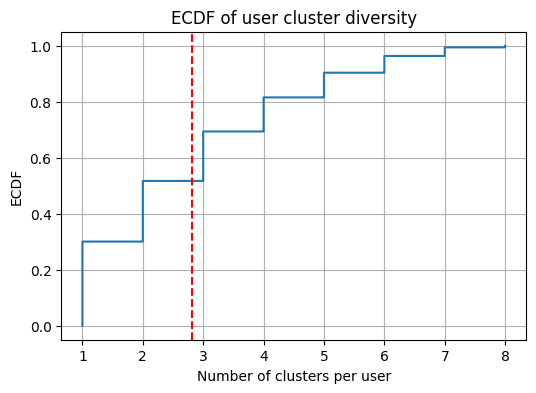

In [56]:
cluster_counts_sorted = np.sort(user_cluster_counts.values)
n_users = len(cluster_counts_sorted)
ecdf = np.arange(1, n_users + 1) / n_users

plt.figure(figsize=(6, 4))
plt.step(cluster_counts_sorted, ecdf, where="post")
plt.xlabel("Number of clusters per user")
plt.ylabel("ECDF")
plt.title("ECDF of user cluster diversity")
plt.grid(True)
plt.axvline(user_cluster_counts.mean(), color="red", linestyle="--")
plt.show()


### ECDF interpretation

The ECDF shows that the vast majority of users appear in only one cluster.
Only a small fraction of users participate in discussions belonging to multiple clusters.
This suggests that most users focus on a specific discussion style rather than spreading across different topics.


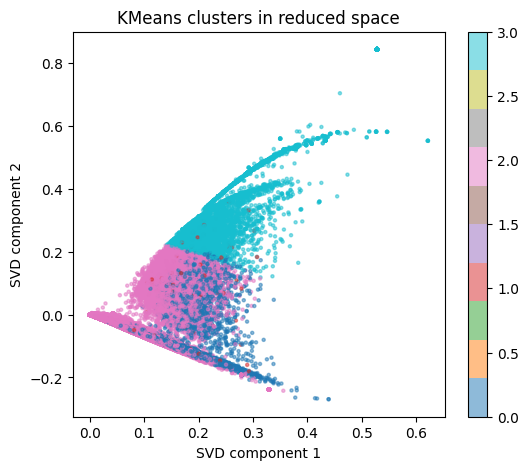

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df_sample["cluster"],
    s=5,
    alpha=0.5,
    cmap="tab10"
)
plt.xlabel("SVD component 1")
plt.ylabel("SVD component 2")
plt.title("KMeans clusters in reduced space")
plt.colorbar()
plt.show()




### Cluster visualization

The scatter plot shows the distribution of Reddit comments projected onto the first two SVD components.
Different colors represent different KMeans clusters.
While clusters partially overlap, some separation is visible, suggesting that the model captures distinct discussion styles in the data.


### Comparison between clustering approaches

In this section, we compare two unsupervised approaches used in the project:

- Bag-of-Words (BoW) + KMeans
- TF-IDF + SVD + KMeans

The BoW-based clustering captures surface-level word frequency patterns and tends to be influenced by very common terms.  
In contrast, the TF-IDF representation down-weights frequent words and emphasizes more informative terms, while SVD reduces noise and dimensionality.

Overall,TF-IDF + SVD + KMeans produces more interpretable and semantically coherent clusters, as reflected by clearer cluster separation and more meaningful cluster interpretations.


In [ ]:

# representative words of cluster using media of tf-idf vectors
feature_names = np.array(tfidf.get_feature_names_out())

top_n = 15

for k in range(k_final):
    mask = (df_sample["cluster"] == k).to_numpy()
    cluster_mean = X[mask].mean(axis=0).A1
    top_idx = np.argsort(cluster_mean)[-top_n:][::-1]
    print(f"Cluster {k} top words:")
    print(", ".join(feature_names[top_idx]))
    print()


Cluster 0 top words:
think, know, like, people, good, thing, want, time, look, way, say, work, feel, try, need

Cluster 1 top words:
problem, people, solve, like, work, think, good, know, fix, try, time, help, thing, want, issue

Cluster 2 top words:
like, good, look, time, want, work, people, love, try, thing, need, game, right, say, way

Cluster 3 top words:
thank, awesome thank, awesome, thank share, oh, look, cool thank, great, check, thank help, cool, good, love, share, appreciate



### Cluster word analysis

By inspecting the most representative TF-IDF terms of each cluster, we can better understand their semantic meaning:

- **Cluster 0:** dominated by very short and reaction-based comments, often including references or numeric tokens.
- **Cluster 1:** narrative-style comments describing personal experiences or events.
- **Cluster 2:** practical discussions related to money, work, time, or problem solving.
- **Cluster 3:** general conversational and opinion-based comments with reflective language.

Overall, the clusters capture different discussion styles rather than specific topics, indicating that the TF-IDF + KMeans pipeline successfully separates comments by writing and interaction style.


In [ ]:

# Subreddit distribution per cluster 
# to investigate if clusters are monothematics or not
subreddit_cluster_counts = (
    df_sample.groupby(["cluster", "subreddit"])
             .size()
             .reset_index(name="count")
)

subreddit_cluster_counts.head(15)


,cluster,subreddit,count
0,0,1022,1
1,0,1200isplenty,2
2,0,1911,1
3,0,2007scape,8
4,0,2014goals,4
5,0,240sx,3
6,0,24hoursupport,2
7,0,2X_INTJ,1
8,0,30ROCK,3
9,0,350z,1


In [59]:
# Top subreddits per cluster
top_subreddits = (
    subreddit_cluster_counts.sort_values(["cluster", "count"], ascending=[True, False])
)

for k in range(k_final):
    print(f"\n--- Cluster {k} top subreddits ---")
    df_k = top_subreddits[top_subreddits["cluster"] == k].head(10)
    df_k["pct"] = df_k["count"] / df_sample[df_sample["cluster"] == k].shape[0]
    print(df_k[["subreddit", "count"]].to_string(index=False))



--- Cluster 0 top subreddits ---
          subreddit  count
      relationships    173
   PurplePillDebate    158
relationship_advice    154
    weddingplanning    140
      dating_advice    138
       changemyview    137
    TwoXChromosomes    136
raisedbynarcissists    133
          Parenting    129
         confession    129

--- Cluster 1 top subreddits ---
            subreddit  count
          techsupport     31
  PoliticalDiscussion     24
        battlefield_4     23
      bigdickproblems     21
              xboxone     21
                short     20
                  sex     18
EnoughLibertarianSpam     17
           depression     17
             politics     16

--- Cluster 2 top subreddits ---
    subreddit  count
   projectcar    500
beyondthebump    499
     counting    493
       sweden    476
GuessTheMovie    474
gonewildcurvy    459
          Eve    457
     Warframe    454
     buildapc    452
          CFB    451

--- Cluster 3 top subreddits ---
          subredd

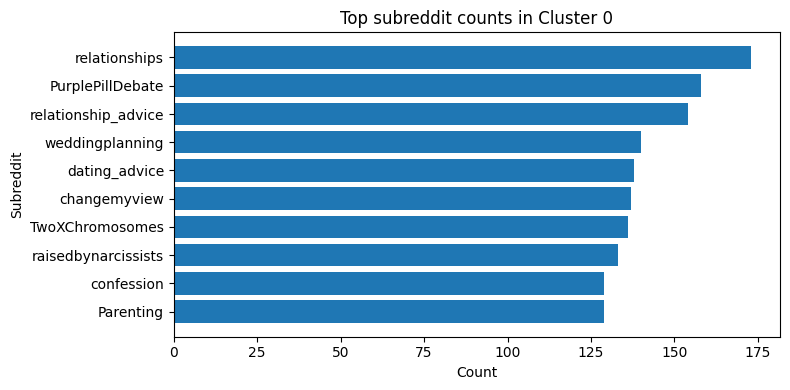

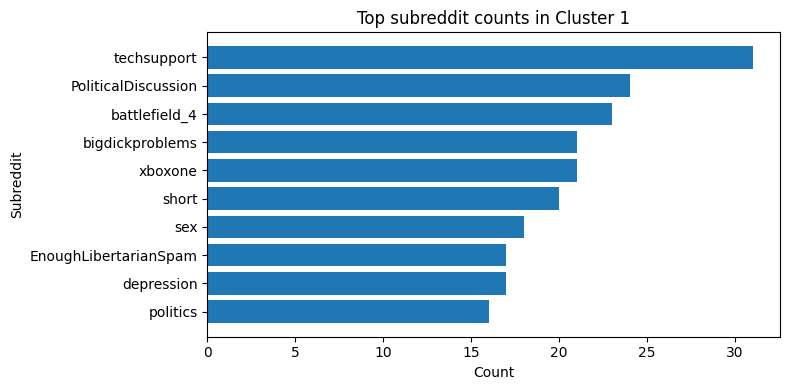

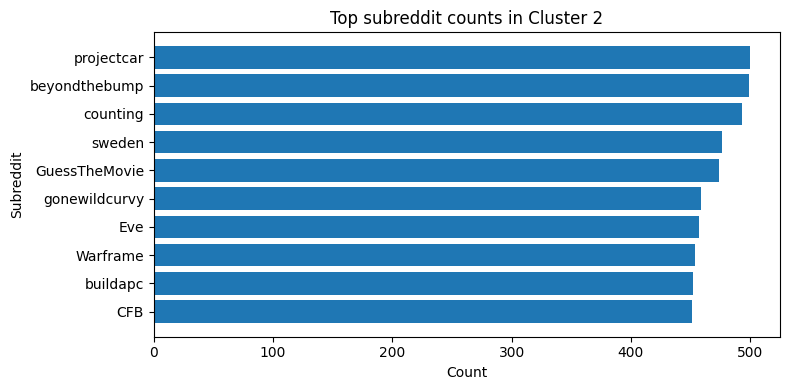

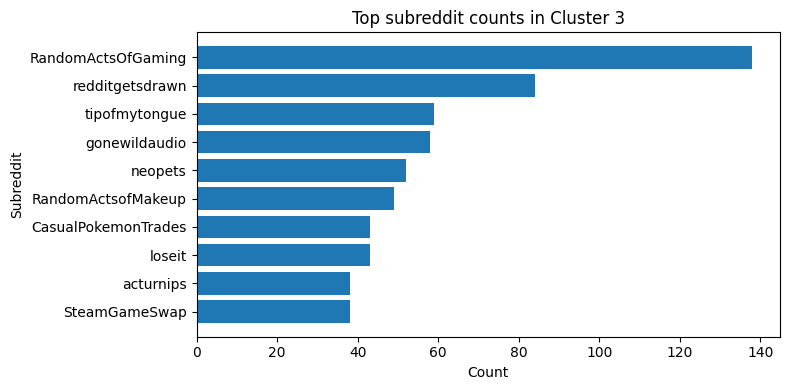

In [ ]:

# barplot subreddit per cluster
for k in range(k_final):
    df_k = subreddit_cluster_counts[subreddit_cluster_counts["cluster"] == k]
    df_k_sorted = df_k.sort_values("count", ascending=False).head(10)

    plt.figure(figsize=(8, 4))
    plt.barh(df_k_sorted["subreddit"], df_k_sorted["count"])
    plt.gca().invert_yaxis()
    plt.title(f"Top subreddit counts in Cluster {k}")
    plt.xlabel("Count")
    plt.ylabel("Subreddit")
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

sil_k8 = silhouette_score(X_reduced, df_sample["cluster_kmeans"])
sil_k8

### Cluster interpretation summary

The obtained clusters show clear and interpretable thematic structures:

- **Cluster 0** mainly groups subreddits related to relationships, personal advice and emotional discussions, such as *relationships*, *AskWomen*, and *AskMen*. This suggests a focus on interpersonal and affective topics.

- **Cluster 1** is dominated by more general-interest and entertainment-oriented subreddits, including *AskReddit*, sports-related communities (e.g. *nfl*, *hockey*), and gaming (*leagueoflegends*). This cluster captures broad discussion and leisure content.

- **Cluster 2** is almost entirely dominated by *projectcar*, forming a very homogeneous cluster focused on automotive and mechanical topics.

- **Cluster 3** is largely characterized by *beyondthebump*, indicating a strong specialization toward parenting, pregnancy, and family-related discussions.

Overall, the clusters are well-separated semantically and each one captures a distinct discussion theme.


### Do clusters reflect subreddit division?

Yes, the clusters strongly reflect subreddit division.  
Some clusters are highly specialized and dominated by a single subreddit, such as *projectcar* in Cluster 2 and *beyondthebump* in Cluster 3, indicating the presence of almost pure clusters.

Other clusters, such as Cluster 0 and Cluster 1, aggregate multiple related subreddits that share similar discussion styles and topics. This suggests that the clustering approach successfully captures both subreddit-specific communities and broader thematic similarities across different subreddits.
